In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
import glob, pandas as pd
import seaborn as sns
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import Pool
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
files = glob.glob('/content/drive/MyDrive/data/givemesomecredit/*')

In [ ]:
files

['/content/drive/MyDrive/data/givemesomecredit/Data Dictionary.xls',
 '/content/drive/MyDrive/data/givemesomecredit/cs-test.csv',
 '/content/drive/MyDrive/data/givemesomecredit/sampleEntry.csv',
 '/content/drive/MyDrive/data/givemesomecredit/cs-training.csv']

In [ ]:
descript = pd.read_excel(files[0], header=1)

In [ ]:
descript

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


In [ ]:
for t in descript['Description']:
  print(t)

Person experienced 90 days past due delinquency or worse 
Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
Age of borrower in years
Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
Monthly debt payments, alimony,living costs divided by monthy gross income
Monthly income
Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
Number of times borrower has been 90 days or more past due.
Number of mortgage and real estate loans including home equity lines of credit
Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
Number of dependents in family excluding themselves (spouse, children etc.)


In [ ]:
train_df = pd.read_csv(files[3], index_col=0)
test_df = pd.read_csv(files[1], index_col=0)
sem_ent = pd.read_csv(files[2], index_col=0)

In [ ]:
sem_ent

,Probability
Id,
1,0.080807
2,0.040719
3,0.011968
4,0.067640
5,0.108264
...,...
101499,0.045363
101500,0.343775
101501,0.006970


In [ ]:
test_df['SeriousDlqin2yrs']  = sem_ent['Probability'].apply(lambda x: 0 if x < 0.5 else 1)

объденим тестовый и тренировочный датасеты в один и затем разделим изх как надо нам

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)

# 1. Анализ и предобработка данных

1.1 Работа с пропущенными значениями

In [ ]:
df.isna().sum()

,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,20107
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0


Пропущенные значения средними значениями для заемщиков аналогичного возраста

In [ ]:
df['MonthlyIncome'] = df.groupby('age')['MonthlyIncome'].transform(
        lambda x: x.fillna((x.mean())))
df['NumberOfDependents'] = df.groupby('age')['NumberOfDependents'].transform(
        lambda x: x.fillna((x.mean())))

In [ ]:
df.isna().sum()

,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,5
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0


In [ ]:
df[df['MonthlyIncome'].isna()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
40007,0,0.064748,107,0,939.0,NaN,9,0,1,0,0.0
56761,0,0.003469,105,0,2.0,NaN,4,0,0,0,NaN
105790,0,0.109307,109,0,2141.0,NaN,17,0,1,0,NaN
138291,0,0.246529,109,0,318.0,NaN,3,0,0,0,NaN
185076,0,0.729798,104,2,1746.0,NaN,12,0,2,1,0.0


Можем удалить стоки с пропущенными значенниями, так как это выбросы

In [ ]:
df = df.dropna()

1.2 Исследуйте выбросы

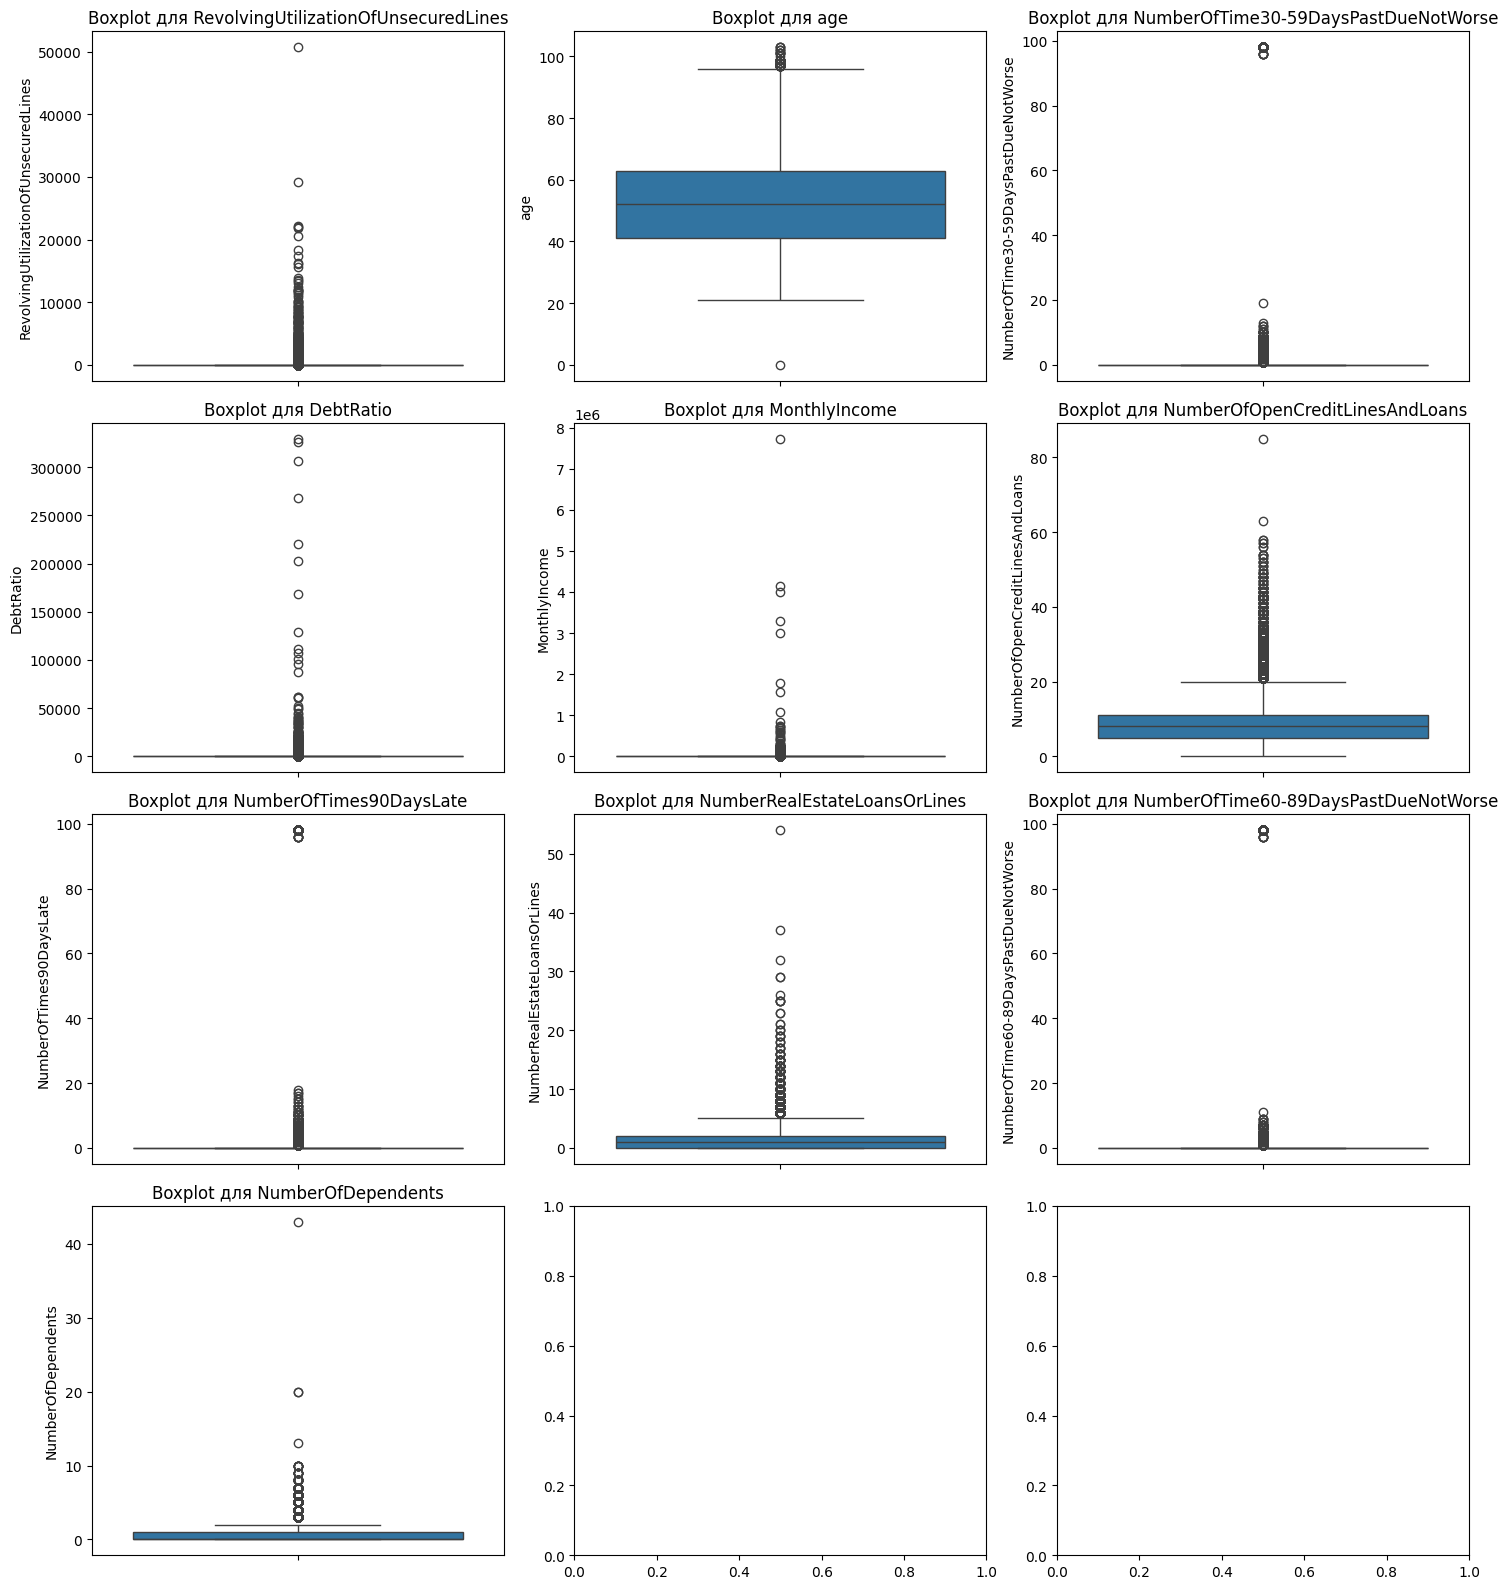

In [ ]:
num_features = train_df.drop(columns = 'SeriousDlqin2yrs').columns
n_cols = 3
n_rows = (len(num_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f"Boxplot для {col}")
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

In [ ]:
df = df[(df['RevolvingUtilizationOfUnsecuredLines']<15000) &
    (0<df['age']) &
    (df['age']<100) &
    (df['NumberOfTime30-59DaysPastDueNotWorse']<20) &
    (df['DebtRatio']<7000) &
    (df['MonthlyIncome']<10000) &
    (df['NumberOfOpenCreditLinesAndLoans']<20) &
    (df['NumberOfTimes90DaysLate']<20) &
    (df['NumberRealEstateLoansOrLines']<7) &
    (df['NumberOfTime60-89DaysPastDueNotWorse']<20) &
    (df['NumberOfDependents']<4)
    ]

1.3 Визуализируйте распределения ключевых признаков.

<ipython-input-470-a256d86c3e9c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')


<Axes: xlabel='SeriousDlqin2yrs', ylabel='count'>

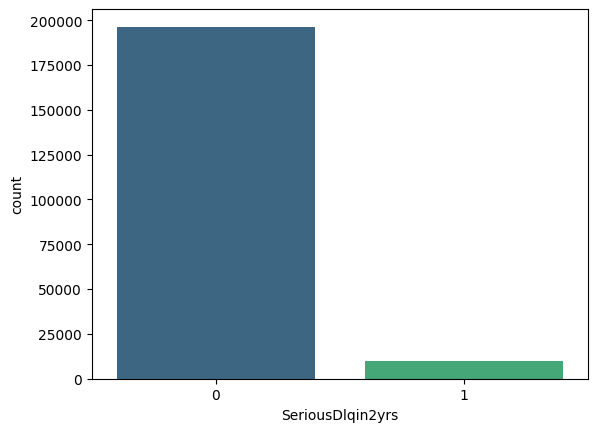

In [ ]:
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')

При отрисовке распределения целевой перменной сразу видна несбалансированность классов

Text(0.5, 1.0, 'Распределение возраста')

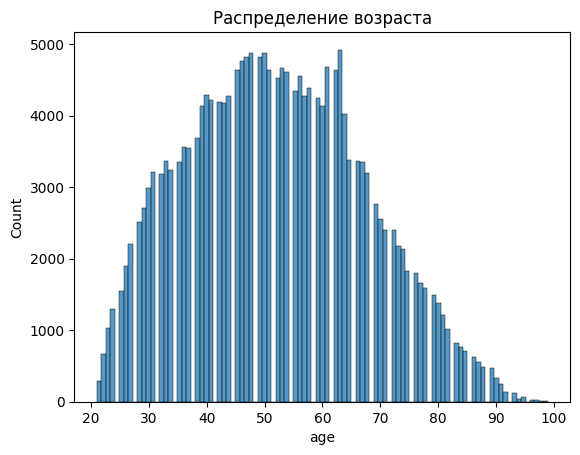

In [ ]:
sns.histplot(df['age'])
plt.title('Распределение возраста')

Text(0.5, 1.0, 'Распределение ежемесячного дохода')

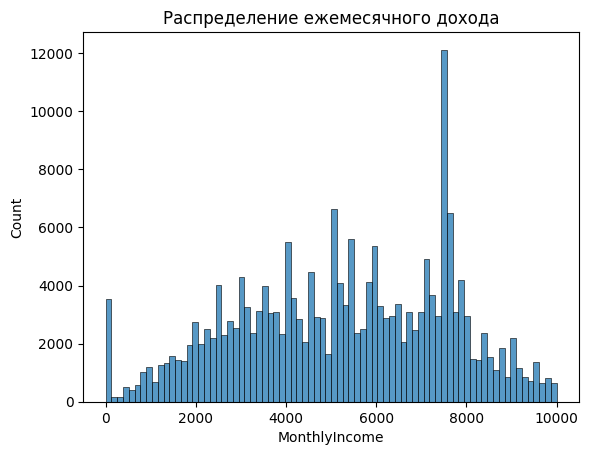

In [ ]:
sns.histplot(df['MonthlyIncome'])
plt.title('Распределение ежемесячного дохода')

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(df['SeriousDlqin2yrs']), y=df['SeriousDlqin2yrs'])

Также в качестве альтернативы для борьбы с дисбалансом классов можно использовать метод  SMOTE.

## 2. Построение и оценка модели

Разделим данные при помощи метода train_test_split

In [ ]:
df['MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: np.log(x))

<ipython-input-474-050c8d7a92f7>:1: RuntimeWarning: divide by zero encountered in log
  df['MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: np.log(x))


In [ ]:
X_train, x_test, Y_train, y_test = train_test_split(
    df.drop(columns='SeriousDlqin2yrs'),
    df['SeriousDlqin2yrs'],
    test_size=0.2,
    stratify=df['SeriousDlqin2yrs'],
    random_state=309
)

In [ ]:
cat_features = ['NumberRealEstateLoansOrLines', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTime30-59DaysPastDueNotWorse', 'age', 'NumberOfTime60-89DaysPastDueNotWorse']

In [ ]:
pool = Pool(
    data=X_train,
    label=Y_train,
    cat_features = cat_features
)

In [ ]:
cb_model = cb.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights = class_weights,
    random_seed=309
)
cb_model.fit(pool)

0:	total: 250ms	remaining: 4m 10s
1:	total: 489ms	remaining: 4m 4s
2:	total: 706ms	remaining: 3m 54s
3:	total: 924ms	remaining: 3m 50s
4:	total: 1.11s	remaining: 3m 40s
5:	total: 1.31s	remaining: 3m 36s
6:	total: 1.51s	remaining: 3m 34s
7:	total: 1.67s	remaining: 3m 26s
8:	total: 1.86s	remaining: 3m 25s
9:	total: 2.11s	remaining: 3m 28s
10:	total: 2.31s	remaining: 3m 28s
11:	total: 2.54s	remaining: 3m 29s
12:	total: 2.75s	remaining: 3m 28s
13:	total: 2.95s	remaining: 3m 27s
14:	total: 3.15s	remaining: 3m 27s
15:	total: 3.34s	remaining: 3m 25s
16:	total: 3.55s	remaining: 3m 25s
17:	total: 3.75s	remaining: 3m 24s
18:	total: 3.95s	remaining: 3m 23s
19:	total: 4.16s	remaining: 3m 24s
20:	total: 4.38s	remaining: 3m 24s
21:	total: 4.61s	remaining: 3m 24s
22:	total: 4.88s	remaining: 3m 27s
23:	total: 5.1s	remaining: 3m 27s
24:	total: 5.28s	remaining: 3m 26s
25:	total: 5.51s	remaining: 3m 26s
26:	total: 5.76s	remaining: 3m 27s
27:	total: 5.96s	remaining: 3m 26s
28:	total: 6.18s	remaining: 3m 2

In [ ]:
pred_proba = cb_model.predict_proba(x_test)

In [ ]:
pred = cb_model.predict(x_test)

1.3 Рассчитайте метрики: AUC-ROC, Precision, Recall, F1-Score.

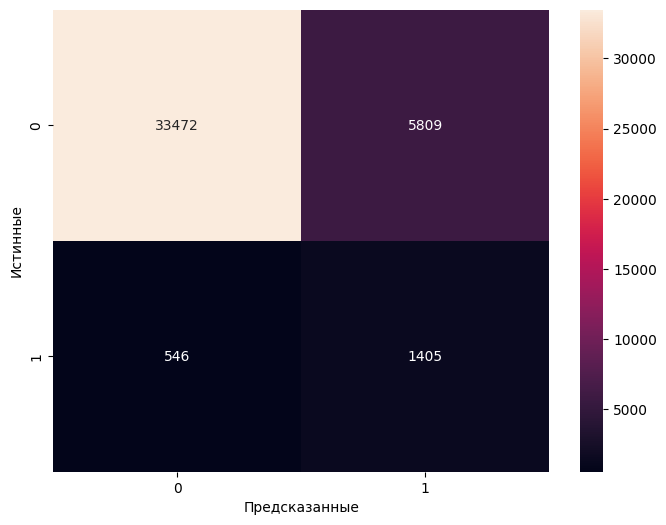

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.show()

In [ ]:
roc_auc_score(y_test, pred)

np.float64(0.7861301578080242)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     39281
           1       0.19      0.72      0.31      1951

    accuracy                           0.85     41232
   macro avg       0.59      0.79      0.61     41232
weighted avg       0.95      0.85      0.88     41232



In [ ]:
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 309,
    'early_stopping_rounds': 50
}

cv_results = cb.cv(
    pool=pool,
    params=params,
    fold_count=5,
    stratified=True,
    shuffle=True,
    partition_random_seed=309,
    verbose=100
)
print(f"Средний AUC: {cv_results['test-AUC-mean'].mean():.3f}")

Training on fold [0/5]
0:	test: 0.8289882	best: 0.8289882 (0)	total: 427ms	remaining: 7m 6s
100:	test: 0.8855785	best: 0.8855785 (100)	total: 21.9s	remaining: 3m 15s
200:	test: 0.8867059	best: 0.8867059 (200)	total: 42.9s	remaining: 2m 50s

bestTest = 0.8867728956
bestIteration = 215

Training on fold [1/5]
0:	test: 0.8256103	best: 0.8256103 (0)	total: 410ms	remaining: 6m 49s
100:	test: 0.8834062	best: 0.8834344 (98)	total: 20.9s	remaining: 3m 6s
200:	test: 0.8842143	best: 0.8842308 (196)	total: 43.2s	remaining: 2m 51s
300:	test: 0.8846665	best: 0.8847309 (294)	total: 1m 4s	remaining: 2m 29s

bestTest = 0.8847308691
bestIteration = 294

Training on fold [2/5]
0:	test: 0.8159320	best: 0.8159320 (0)	total: 228ms	remaining: 3m 47s
100:	test: 0.8779692	best: 0.8779731 (99)	total: 19.9s	remaining: 2m 57s
200:	test: 0.8791633	best: 0.8791633 (200)	total: 42.4s	remaining: 2m 48s
300:	test: 0.8798216	best: 0.8798486 (298)	total: 1m 3s	remaining: 2m 26s
400:	test: 0.8804952	best: 0.8805058 (399

In [ ]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.820747,0.006187,0.536144,0.000478,0.536118,0.000284
1,1,0.831618,0.012267,0.428698,0.000922,0.428677,0.001020
2,2,0.846141,0.007710,0.351597,0.002393,0.351529,0.002179
3,3,0.849366,0.010689,0.295174,0.001594,0.295084,0.001574
4,4,0.850936,0.011879,0.256787,0.003381,0.256691,0.003351
...,...,...,...,...,...,...,...
621,621,0.881808,0.003826,0.129900,0.001054,0.120317,0.002569
622,622,0.881806,0.003827,0.129901,0.001055,0.120312,0.002576
623,623,0.881806,0.003827,0.129902,0.001057,0.120307,0.002583
624,624,0.881802,0.003828,0.129902,0.001057,0.120303,0.002589


## 3. Интерпретация и этика

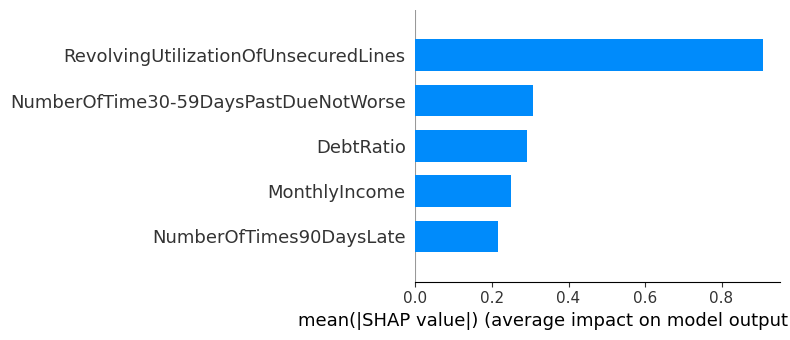

In [ ]:
import shap

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test, plot_type="bar", max_display=5)

Влияние признаков логично. При том, что заемщик уже просрочивал платеж на несколько месяцев, то вероятно, что он сделает это снова. Также призанки RevolvingUtilizationOfUnsecuredLines и MonthlyIncome также должны сильно влиять на предсказания целевой переменной, так как при меньшем остатке денег на счетах и меньшем доходе есть большая вероятность просрочки платежа.

3.3 Оцените fairness модели: сравните метрики (FPR, TPR) для групп (например, молодые vs старше 40 лет)

In [ ]:
mask = x_test['age'] < 40
tn1, fp1, fn1, tp1 = confusion_matrix(y_test[mask], pred[mask]).ravel()
fpr_young = fp1 / (fp1 + tn1)
tpr_young = tp1 / (tp1 + fn1)

tn2, fp2, fn2, tp2 = confusion_matrix(y_test[~mask], pred[~mask]).ravel()
fpr_old = fp2 / (fp2 + tn2)
tpr_old = tp2 / (tp2 + fn2)

print(f"FPR для <40 лет: {fpr_young:.3f}, для >=40 лет: {fpr_old:.3f}")
print(f"TPR для <40 лет: {tpr_young:.3f}, для >=40 лет: {tpr_old:.3f}")

FPR для <40 лет: 0.243, для >=40 лет: 0.117
TPR для <40 лет: 0.743, для >=40 лет: 0.693


4. Отчет. \
Модель отлично предсказывает заемщиков отсутствие дефолта, но нестабильна в предсказании заемщиков с дефолтом. Для улучшения качества можно попробовать использовать методы борьбы с дисбалансом классов по типу: SMOTE, undersampling, oversampling. \
Также можно попробовать собрать дополнительные данные, например место работы, регион проживания, или средние траты в месяц.